# PBS genome-wide selection scans

In [1]:
%run setup.ipynb

In [2]:
df_samples.head()

,ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
0,AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
1,AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.70,ERS311886,5.60858,-1.54926
2,AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
3,AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
4,AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


In [3]:
df_haps_a.groupby(['population', 'region']).size()

population  region           
AOcol       Luanda               156
BFcol       Bana                  12
            Bana M                36
            Bana V                32
            Pala                  20
            Sour                  50
BFgam       Bana                  34
            Bana M                 4
            Bana V                 2
            Pala                  92
            Sour                  52
CIcol       Tiassale             142
CMgam       Daiguene             192
            Gado-Badzere         146
            Mayos                210
            Zembe-Borongo         46
FRgam       Mayotte               48
GAgam       Libreville           138
GHcol       Koforidua              2
            Madina                24
            Takoradi              40
            Twifo_Praso           44
GHgam       Madina                24
GM          KBK                   38
            KSK                   16
            MSN                   36
        

In [4]:
df_samples.groupby(['population', 'location']).size()

population  location      
AOcol       Luanda             78
BFcol       Bana               40
            Pala               10
            Souroukoudinga     25
BFgam       Bana               20
            Pala               46
            Souroukoudinga     26
CIcol       Tiassale           71
CMgam       Daiguene           96
            Gado Badzere       73
            Mayos             105
            Zembe Borongo      23
FRgam       Mayotte            24
GAgam       Libreville         69
GHcol       Koforidua           1
            Madina             12
            Takoradi           20
            Twifo Praso        22
GHgam       Madina             12
GM          Njabakunda         65
GNcol       Koundara            4
GNgam       Koraboh            22
            Koundara           18
GQgam       Bioko               9
GW          Antula             58
            Safim              33
KE          Kilifi             48
UGgam       Tororo            112
dtype: int64

N.B., there are some inconsistencies between the sample and haplotype metadata, regarding representation of collection location, beware of these.

In [5]:
def compute_pbs_region(pop1, pop2, pop3, seq_id, start=None, stop=None, 
                       window_size=100, window_step=100, normed=True, 
                       min_maf=None):
    
    # load variant positions
    pos = callset_pass[seq_id]['variants/POS'][:]

    # setup genotypes
    gt = allel.GenotypeDaskArray(callset_pass[seq_id]['calldata/GT'])

    
    if start or stop:
        loc_region = allel.SortedIndex(pos).locate_range(start, stop)
        pos = pos[loc_region]
        gt = gt[loc_region]
    
    # compute allele counts
    acs = list()
    for pop in pop1, pop2, pop3:
        # fix query for differences between samples and haplotypes metadata
        pop_query = (
            pop_defs[pop]['query']
            .replace('region', 'location')
            .replace('Gado-Badzere', 'Gado Badzere')
            .replace('Zembe-Borongo', 'Zembe Borongo')
        )
        loc_pop = df_samples.query(pop_query).index.values
        # check consistency between samples and haplotypes metadata
        assert len(loc_pop) * 2 == len(df_haps_a.query(pop_defs[pop]['query']))
        ac = gt.take(loc_pop, axis=1).count_alleles(max_allele=3)
        acs.append(ac)
    ac1, ac2, ac3 = da.compute(*acs)

    # locate segregating variants
    ac = allel.AlleleCountsArray(ac1 + ac2 + ac3)
    if min_maf:
        loc_seg = ac.is_biallelic_01() & (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    else:
        loc_seg = ac.is_segregating()
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    pos = pos[loc_seg]
    
    # setup windows
    windows = allel.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], 
                                     size=window_size, step=window_step)
    
    # compute pbs
    pbs = allel.pbs(ac1, ac2, ac3, window_size=window_size, 
                    window_step=window_step, normed=normed)

    return windows, pbs

In [6]:
# inversion coordinates, tweaked from data
# start_2rb = 19_444_433
# stop_2rb = 26_313_071
start_2rb = 19_000_000
stop_2rb = 26_770_000
start_2la = 20_528_089
# stop_2la = 42_165_182
stop_2la = 42_200_000


def compute_pbs(pop1, pop2, pop3, chromosome, window_size=100, window_step=100, normed=True, min_maf=None):
    
    if chromosome == 'X':
        regions = ('X', None, None),
        
    elif chromosome == '3':
        regions = ('3R', None, None), ('3L', None, None)
        
    elif chromosome == '2':
        regions = (
            # 2R up to beginning of 2Rb
            ('2R', None, start_2rb),
            # 2Rb
            ('2R', start_2rb, stop_2rb),
            # remainder of 2R
            ('2R', stop_2rb, None),
            # 2L up to beginning of 2La
            ('2L', None, start_2la),
            # 2La
            ('2L', start_2la, stop_2la),
            # remainder of 2L
            ('2L', stop_2la, None)
        )
        
    else:
        raise ValueError
        
    results = []
    for seq_id, start, stop in regions:
        windows, pbs = compute_pbs_region(pop1=pop1, pop2=pop2, pop3=pop3, seq_id=seq_id, start=start, stop=stop, 
                                          window_size=window_size, window_step=window_step, normed=normed, min_maf=min_maf)
        if seq_id == '3L':
            windows = windows + len(genome['3R'])
        elif seq_id == '2L':
            windows = windows + len(genome['2R'])
        results.append([windows, pbs])
        
    windows = np.concatenate([r[0] for r in results], axis=0)
    gwindows = gmap[chromosome].take(windows)

    if chromosome in {'X', '3'}:
        # concatenate, then standardize across whole chromosome
        pbs = np.concatenate([r[1] for r in results], axis=0)
        centre_val = np.median(pbs)
        scale_val = scipy.stats.iqr(pbs)
        pbs_scaled = (pbs - centre_val) / scale_val
            
    elif chromosome == '2':
        # special case, standardise inversions separately
        pbs_noinv = np.concatenate([r[1] for i, r in enumerate(results) if i in {0, 2, 3, 5}])
        pbs_2rb = results[1][1]
        pbs_2la = results[4][1]
        centre_noinv = np.median(pbs_noinv)
        scale_noinv = scipy.stats.iqr(pbs_noinv)
        centre_2rb = np.median(pbs_2rb)
        scale_2rb = scipy.stats.iqr(pbs_2rb)
        centre_2la = np.median(pbs_2la)
        scale_2la = scipy.stats.iqr(pbs_2la)
        centre_vals = [centre_noinv, centre_2rb, centre_noinv, centre_noinv, centre_2la, centre_noinv]
        scale_vals = [scale_noinv, scale_2rb, scale_noinv, scale_noinv, scale_2la, scale_noinv]
        for result, centre_val, scale_val in zip(results, centre_vals, scale_vals):
            x = (result[1] - centre_val) / scale_val
            result.append(x)
        # now concatenate
        pbs = np.concatenate([r[1] for r in results], axis=0)
        pbs_scaled = np.concatenate([r[2] for r in results], axis=0)
        
    else:
        raise ValueError
    
    return windows, gwindows, pbs, pbs_scaled
    

In [7]:
pbs_root = zarr.open(str(here() / 'data/gwss/pbs/pbs.zarr'))

In [8]:
def run_pbs(pop1, pop2, pop3, chromosome, window_size=100, window_step=100, normed=True, markersize=1, min_maf=None, 
            physical=True, genetic=True, fig_scale=1e-7, plot_scaled=True):

    # setup zarr group to store data
    grp_path = f'/{pop1}_{pop2}_{pop3}/{window_size}/{window_step}/{chromosome}'
    grp = pbs_root.require_group(grp_path)
    complete = grp.attrs.get('complete', False)

    if complete:
        # previously run, load from zarr
        windows = grp['windows'][:]
        gwindows = grp['gwindows'][:]
        pbs = grp['pbs'][:]
        pbs_scaled = grp['pbs_scaled'][:]
        
    else:
        # run scan and save to zarr
        windows, gwindows, pbs, pbs_scaled = compute_pbs(
            pop1, pop2, pop3, chromosome, 
            window_size=window_size, 
            window_step=window_step, 
            normed=normed, 
            min_maf=min_maf
        )
        grp.create_dataset('windows', data=windows, overwrite=True)
        grp.create_dataset('gwindows', data=gwindows, overwrite=True)
        grp.create_dataset('pbs', data=pbs, overwrite=True)
        grp.create_dataset('pbs_scaled', data=pbs_scaled, overwrite=True)
        grp.attrs['complete'] = True

    # scale figures to chromosome size
    figwidth = windows.max()*fig_scale
    
    if plot_scaled:
        y = pbs_scaled.clip(min=0, max=50)
        ylim = 0, 51
        ylabel = 'scaled PBS'
    else:
        y = pbs.clip(0, 0.3)
        ylim = 0, 0.31
        ylabel = 'PBS'

    # plot results for inspection - physical space
    if physical:
        x = windows.mean(axis=1)
        fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
        ax.plot(x, y, linestyle=' ', mfc='none', marker='o', color='purple', markersize=markersize)
        ax.set_xlabel(f'Chromosome {chromosome} position (Mbp)')
        ax.set_ylabel(ylabel)
        ax.set_title(f"PBS({pop1}, ({pop2}, ({pop3}))")
        xlim = 0, windows.max()
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks/1e6)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    
    # plot results for inspection - genetic space
    if genetic:
        x = gwindows.mean(axis=1)
        fig, ax = plt.subplots(facecolor='w', figsize=(figwidth, 3))
        ax.plot(x, y, linestyle=' ', mfc='none', marker='o', color='purple', markersize=markersize)
        ax.set_xlabel(f'Chromosome {chromosome} position (cM)')
        ax.set_ylabel(ylabel)
        ax.set_title(f"PBS({pop1}, ({pop2}, ({pop3}))")
        xlim = 0, gwindows.max()
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    
    plt.show()
    plt.close()

In [9]:
list(pop_defs)

['ao_col',
 'bf_col',
 'bf_gam',
 'ci_col',
 'cm_sav_gam',
 'fr_gam',
 'ga_gam',
 'gh_col',
 'gh_gam',
 'gm',
 'gn_gam',
 'gq_gam',
 'gw',
 'ke',
 'ug_gam']

In [10]:
comparisons = (
    # Angola An. coluzzii
    ('ao_col', 'ga_gam', 'gw'),
    ('ao_col', 'ga_gam', 'gq_gam'),
    ('ao_col', 'bf_col', 'gw'),
    ('ao_col', 'bf_col', 'gq_gam'),
    # Burkina Faso An. coluzzii
    ('bf_col', 'bf_gam', 'gw'),
    ('bf_col', 'bf_gam', 'gq_gam'),
    ('bf_col', 'gh_col', 'gw'),
    ('bf_col', 'gh_col', 'gq_gam'),
    ('bf_col', 'ao_col', 'gq_gam'),
    # Burkina Faso An. gambiae
    ('bf_gam', 'bf_col', 'gw'),
    ('bf_gam', 'bf_col', 'gq_gam'),
    ('bf_gam', 'ug_gam', 'gw'),
    ('bf_gam', 'ug_gam', 'gq_gam'),
    # Cote d'Ivoire An. coluzzii
    ('ci_col', 'bf_gam', 'gw'),
    ('ci_col', 'bf_gam', 'gq_gam'),
    ('ci_col', 'bf_col', 'gw'),
    ('ci_col', 'bf_col', 'gq_gam'),
    ('ci_col', 'ao_col', 'gq_gam'),
    # Cameroon An. gambiae
    ('ca_sav_gam', 'bf_col', 'gw'),
    ('ca_sav_gam', 'bf_col', 'gq_gam'),
    ('ca_sav_gam', 'bf_gam', 'gw'),
    ('ca_sav_gam', 'bf_gam', 'gq_gam'),
    ('ca_sav_gam', 'ug_gam', 'gw'),
    ('ca_sav_gam', 'ug_gam', 'gq_gam'),
    # Mayotte An. gambiae
    ('fr_gam', 'ug_gam', 'gw'),
    ('fr_gam', 'ug_gam', 'gq_gam'),
    ('fr_gam', 'gq_gam', 'bf_col'),
    # Gabon An. gambiae
    ('ga_gam', 'ug_gam', 'gw'),
    ('ga_gam', 'ug_gam', 'gq_gam'),
    # Ghana An. coluzzii
    ('gh_col', 'bf_gam', 'gw'),
    ('gh_col', 'bf_gam', 'gq_gam'),
    ('gh_col', 'bf_col', 'gw'),
    ('gh_col', 'bf_col', 'gq_gam'),
    ('gh_col', 'ao_col', 'gq_gam'),
    # Ghana An. gambiae
    ('gh_gam', 'gh_col', 'gw'),
    ('gh_gam', 'gh_col', 'gq_gam'),
    ('gh_gam', 'ug_gam', 'gw'),
    ('gh_gam', 'ug_gam', 'gq_gam'),
    # The Gambia
    ('gm', 'bf_gam', 'gq_gam'),
    ('gm', 'bf_col', 'gq_gam'),
    ('gm', 'gw', 'gq_gam'),
    ('gm', 'ug_gam', 'gq_gam'),
    # Guinea An. gambiae
    ('gn_gam', 'bf_col', 'gw'),
    ('gn_gam', 'bf_col', 'gq_gam'),
    ('gn_gam', 'ug_gam', 'gw'),
    ('gn_gam', 'ug_gam', 'gq_gam'),
    # Bioko An. gambiae
    ('gq_gam', 'ug_gam', 'bf_col'),
    ('gq_gam', 'ug_gam', 'gw'),
    # Guinea-Bissau
    ('gw', 'bf_gam', 'gq_gam'),
    ('gw', 'bf_col', 'gq_gam'),
    ('gw', 'gm', 'gq_gam'),
    ('gw', 'ug_gam', 'gq_gam'),
    # Kenya
    ('ke', 'ug_gam', 'gw'),
    ('ke', 'ug_gam', 'gq_gam'),
    ('ke', 'gq_gam', 'bf_col'),
    # Uganda An. gambiae
    ('ug_gam', 'bf_gam', 'gw'),
    ('ug_gam', 'bf_gam', 'gq_gam'),
)

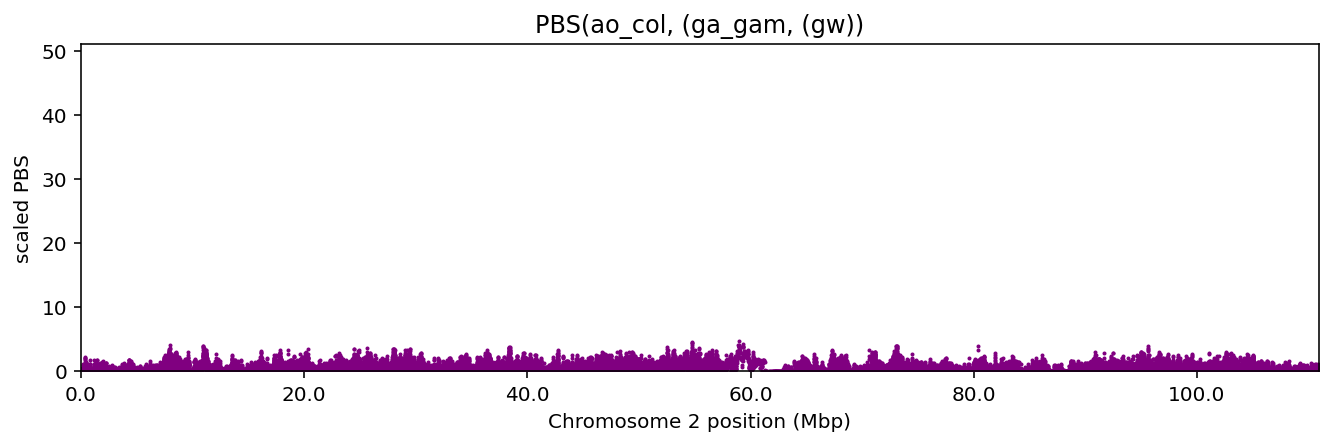

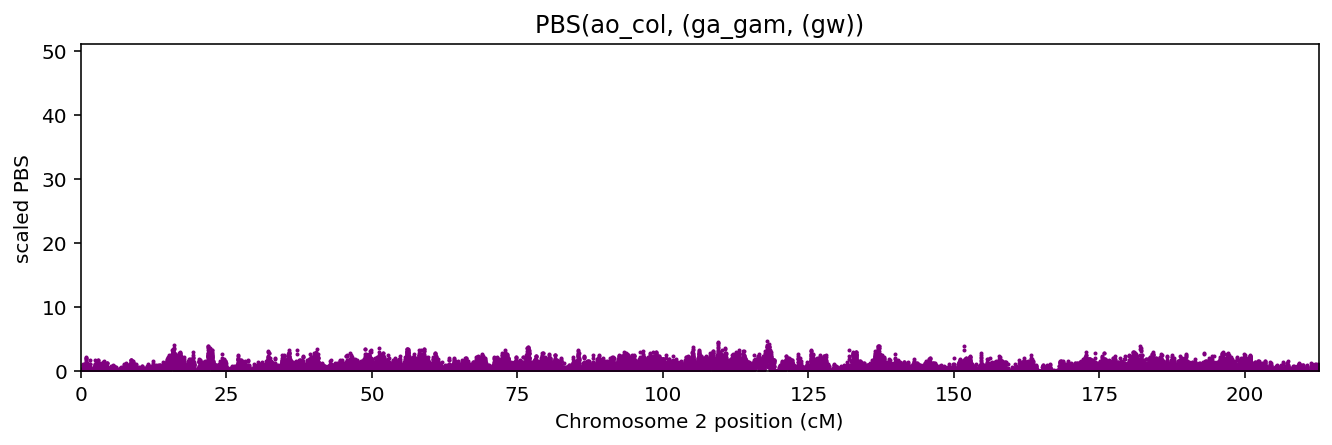

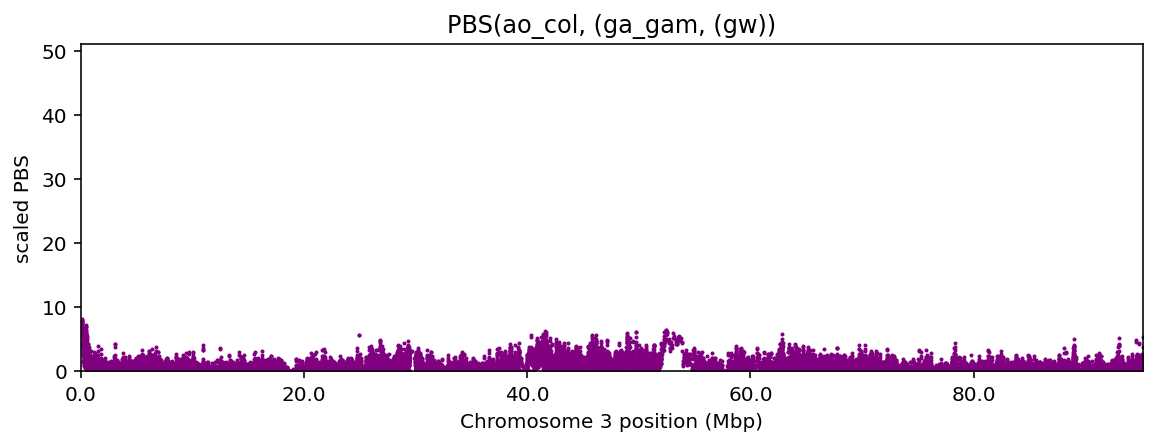

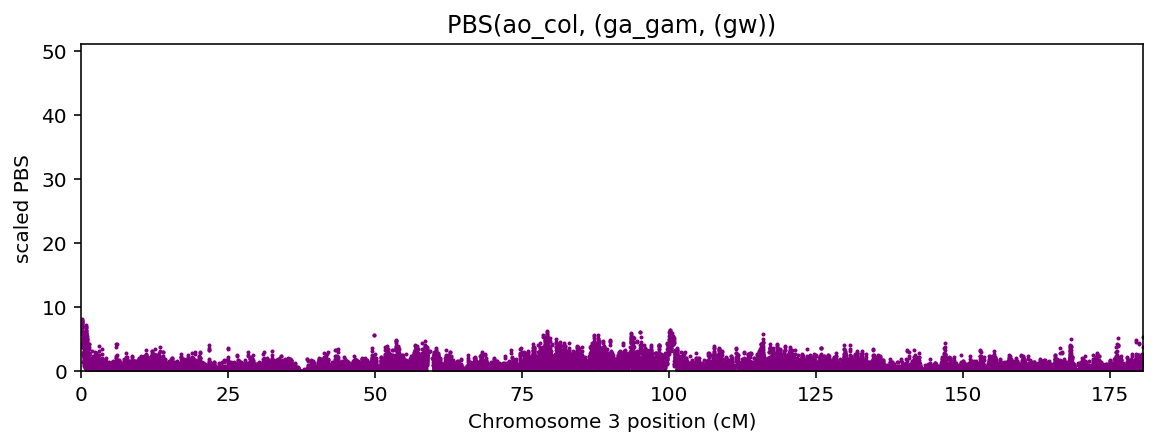

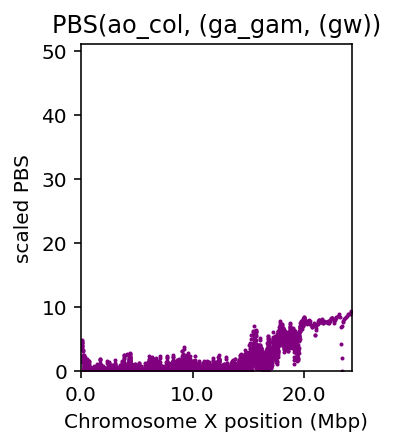

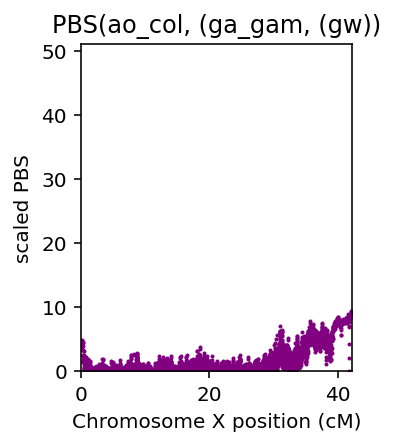

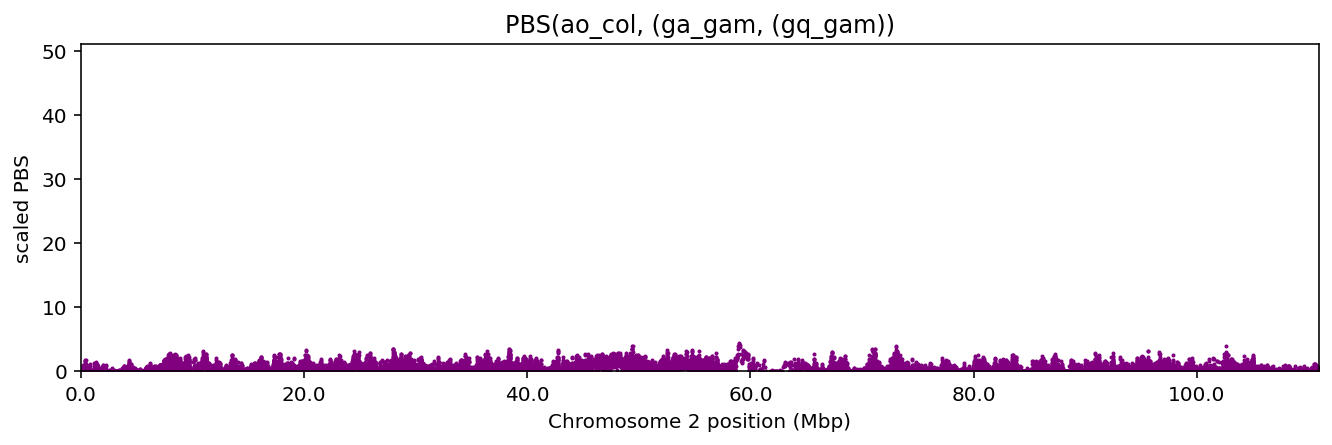

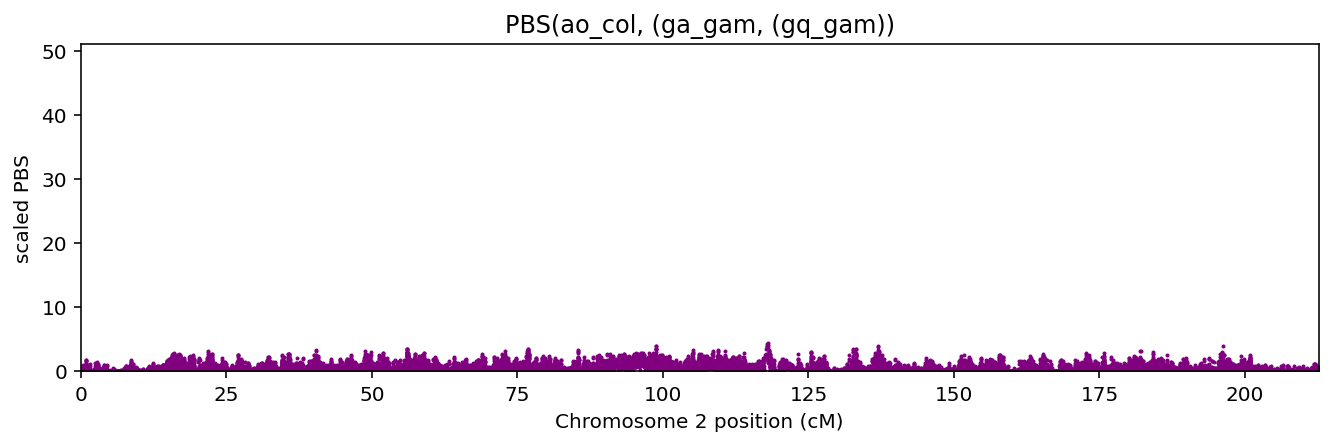

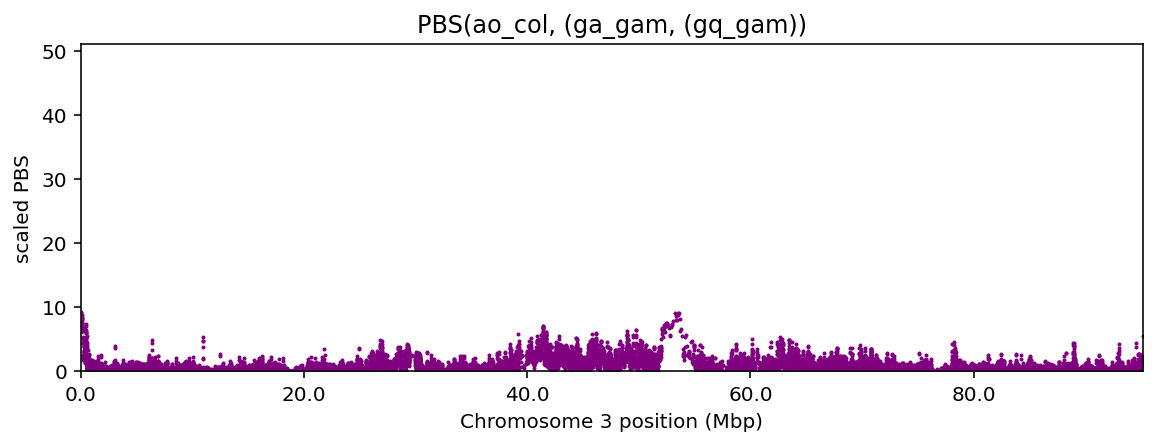

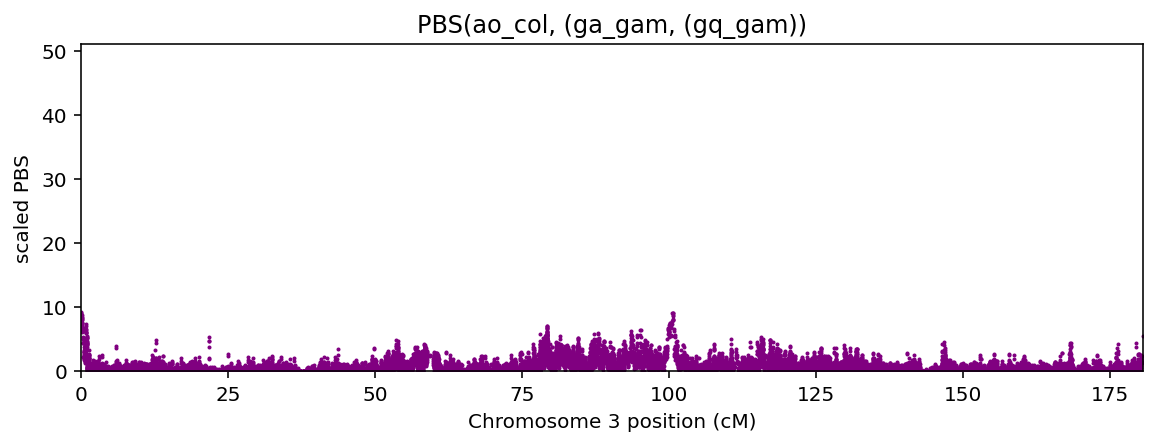

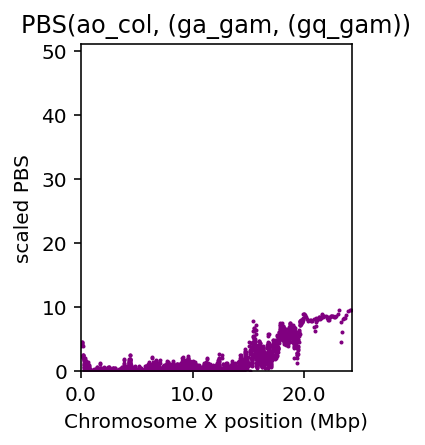

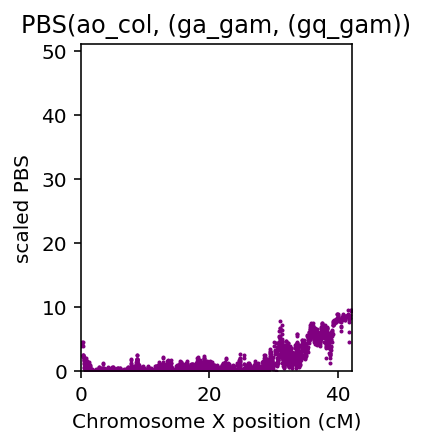

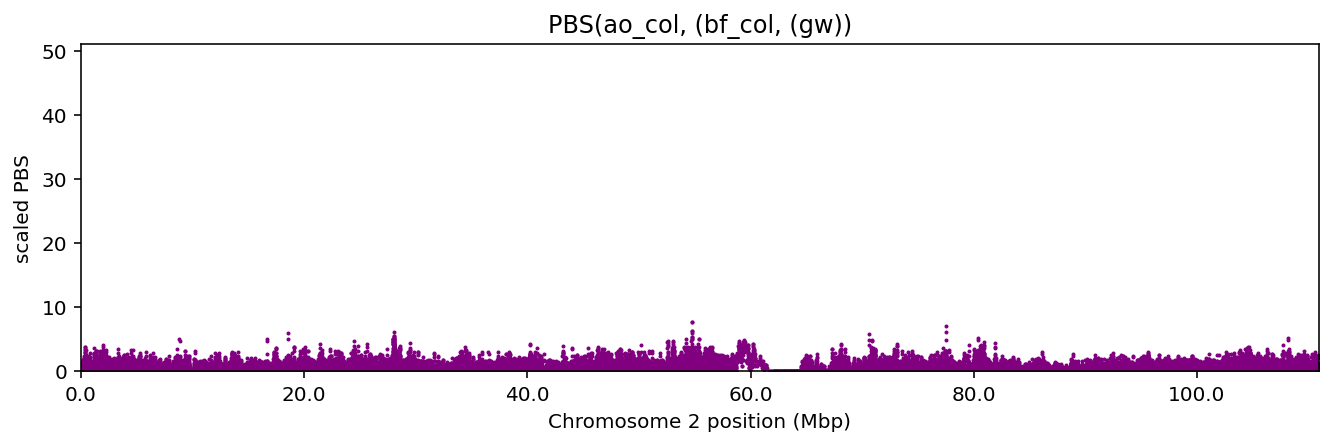

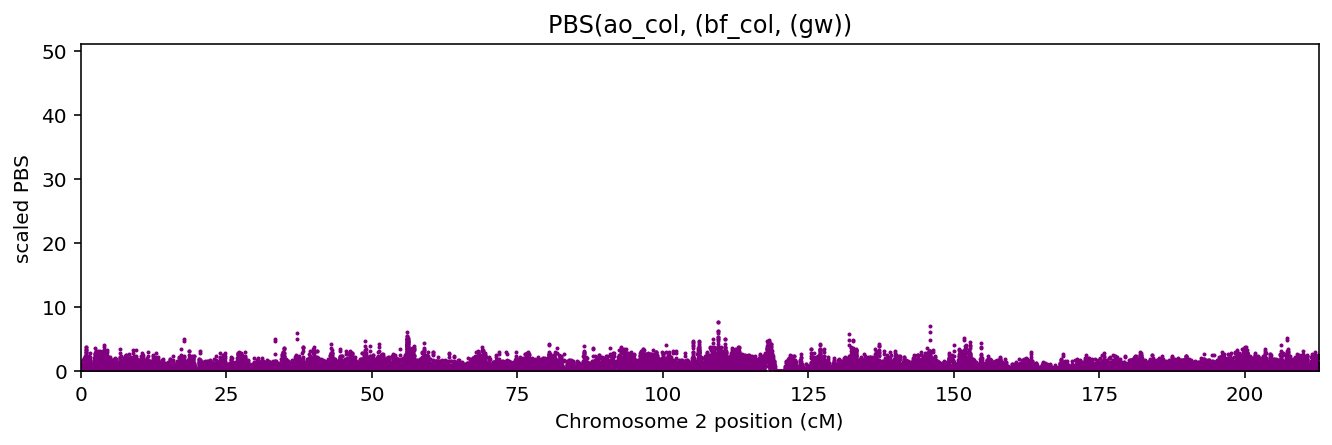

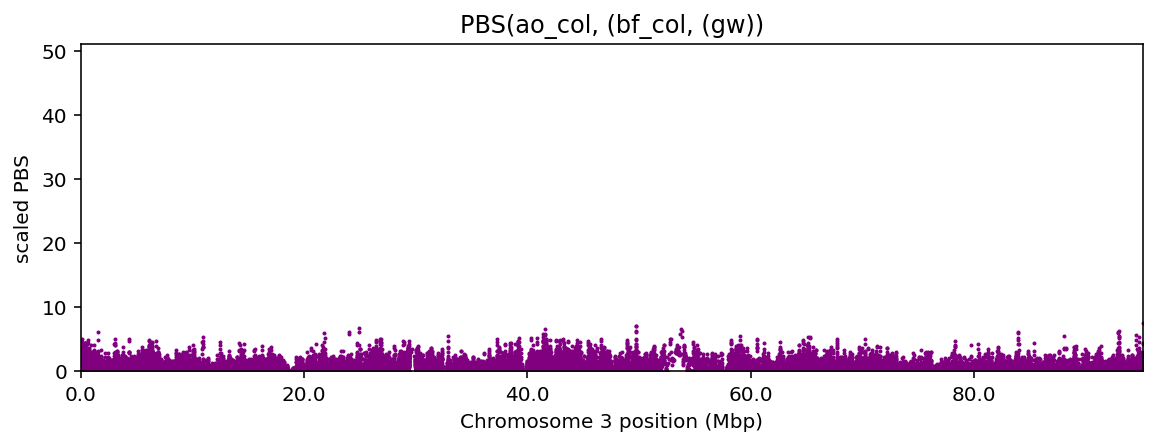

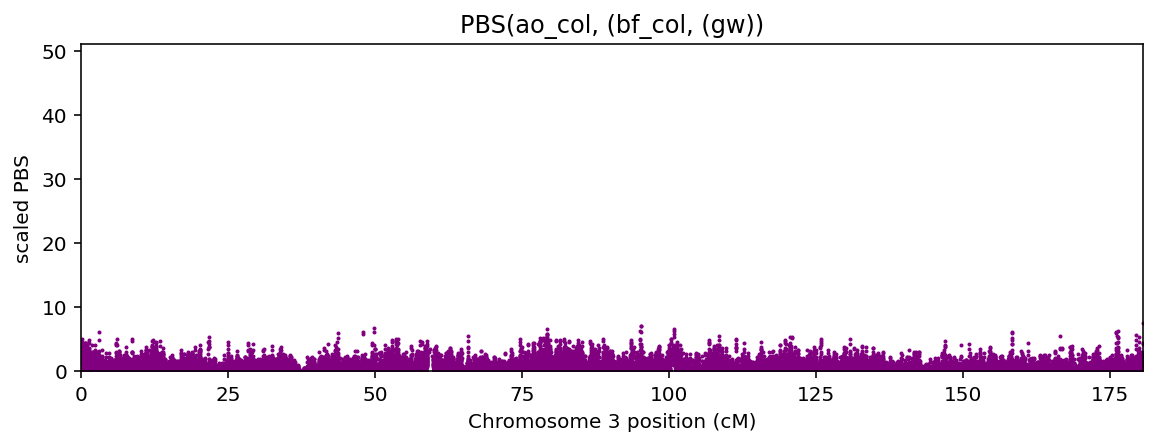

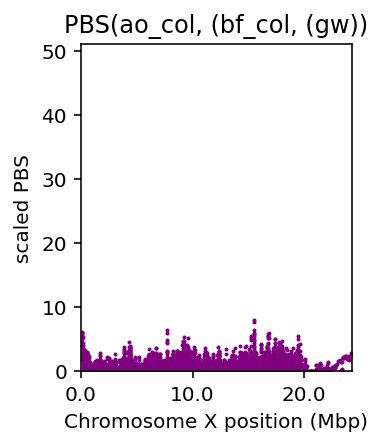

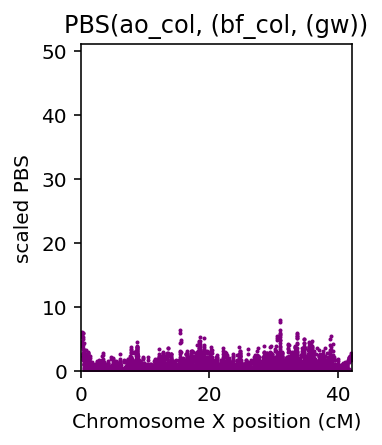

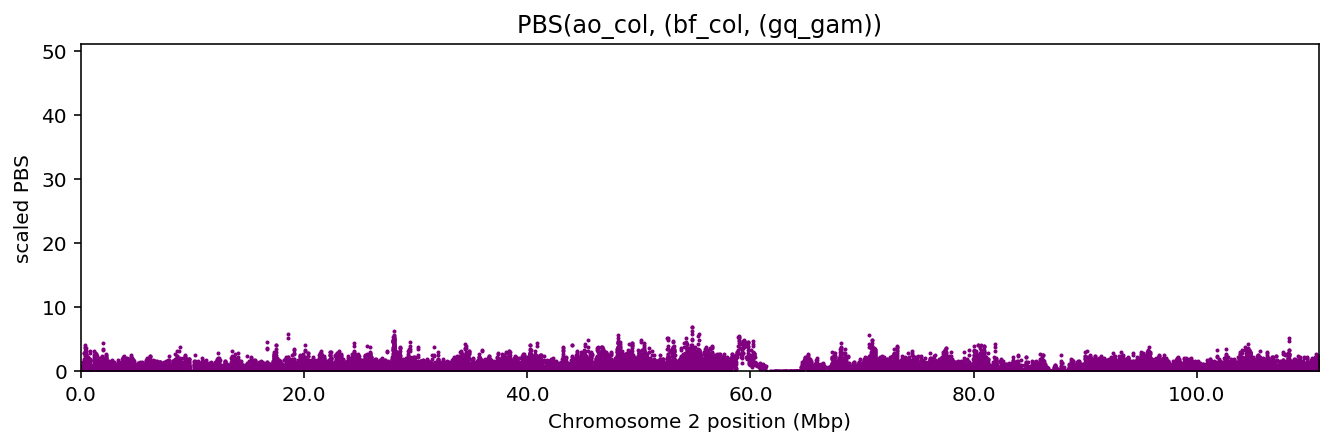

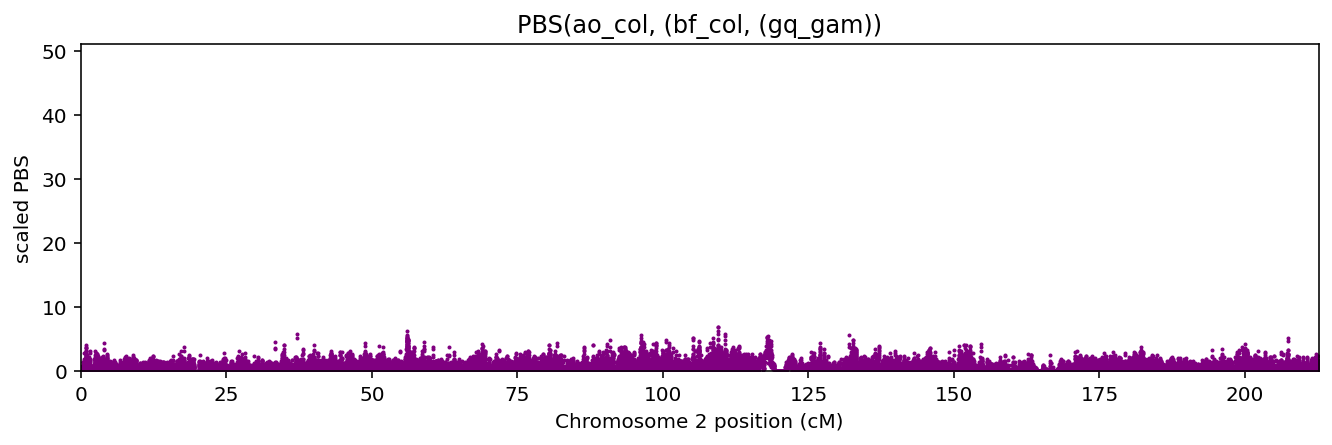

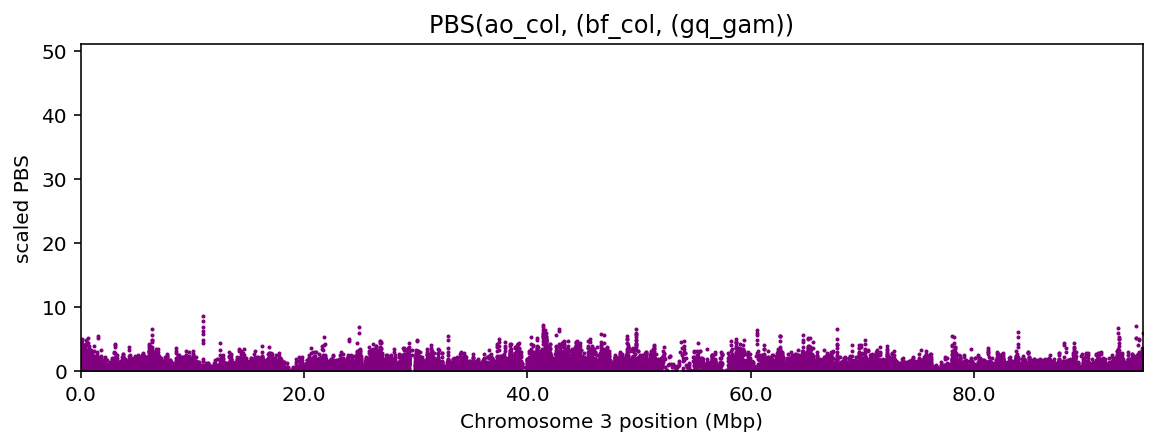

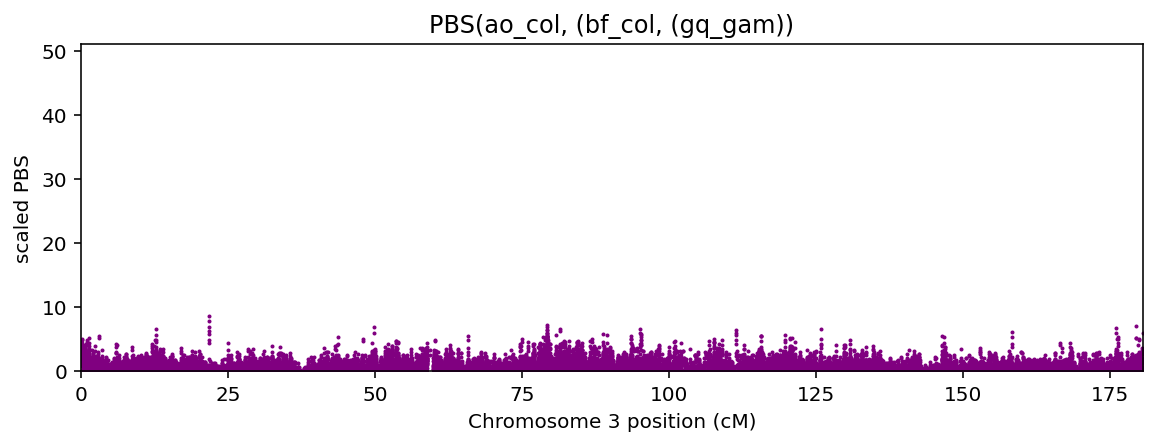

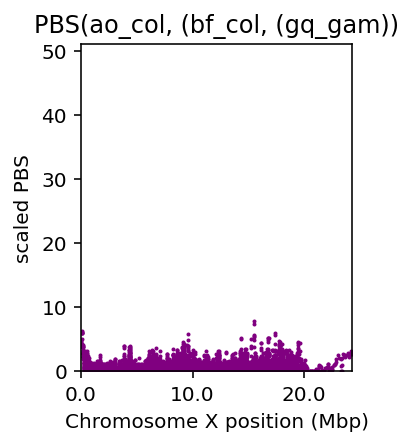

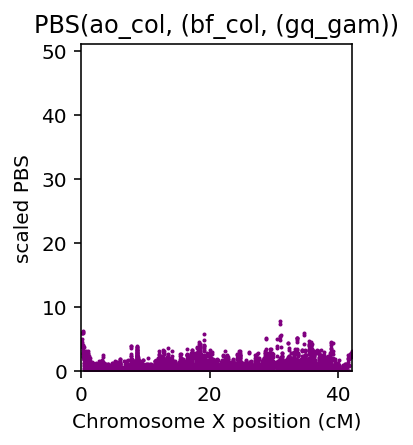

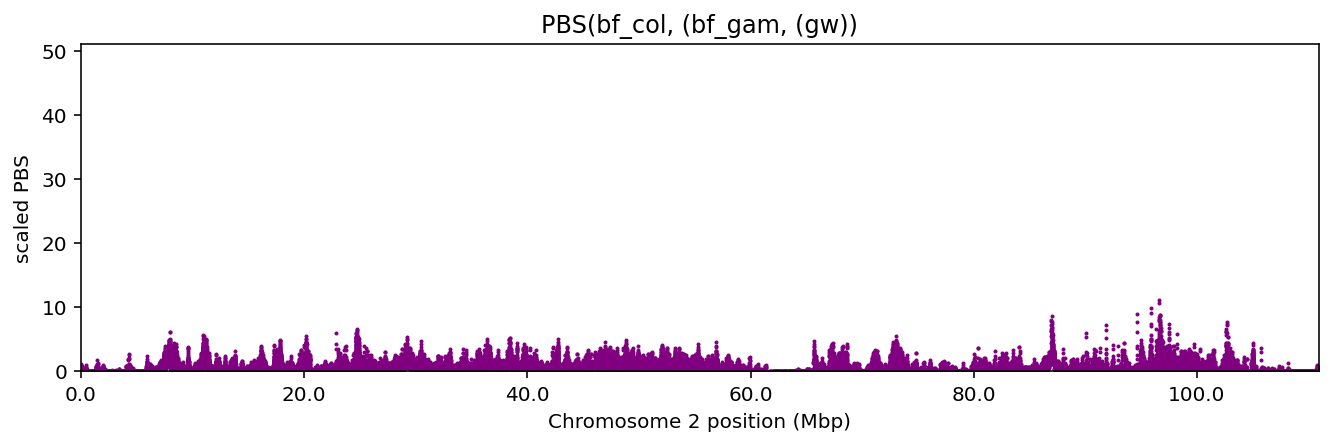

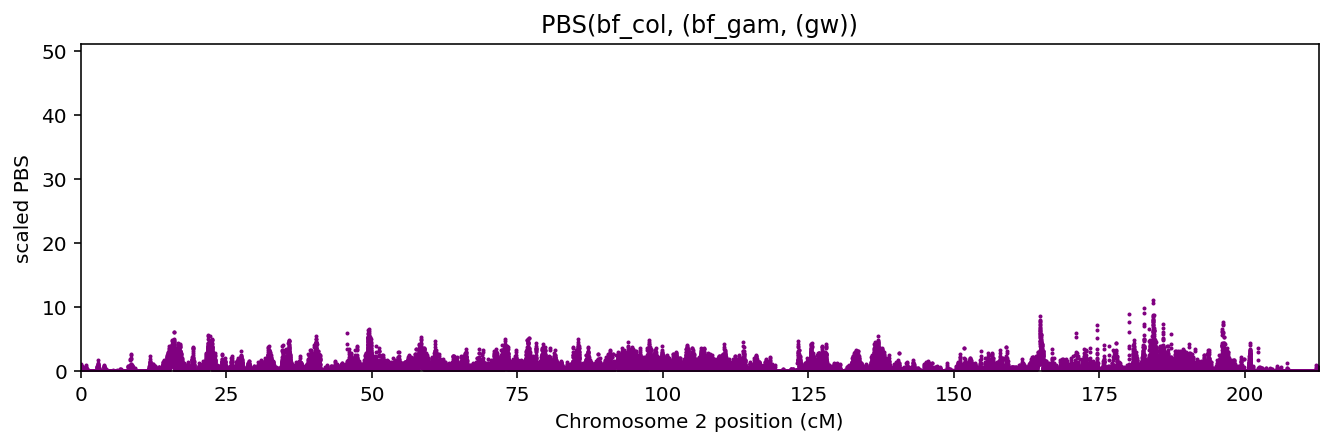

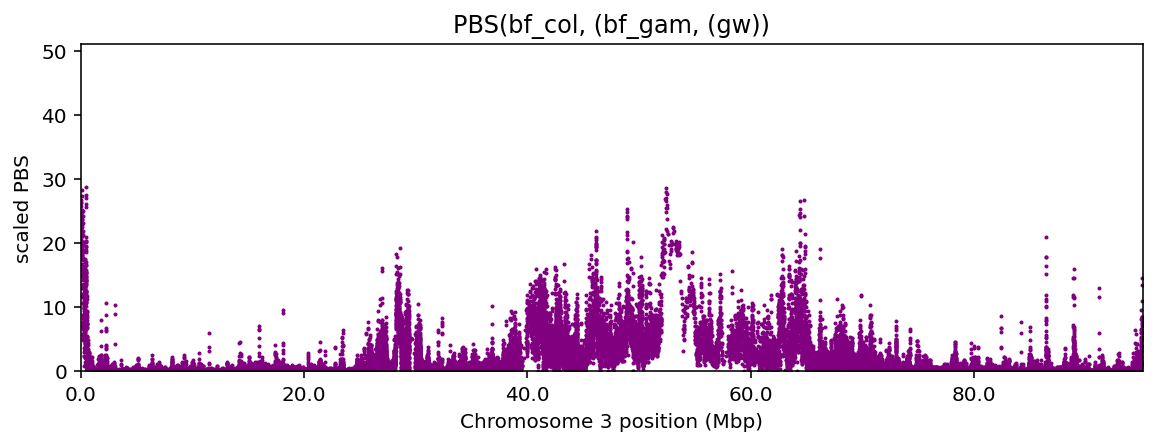

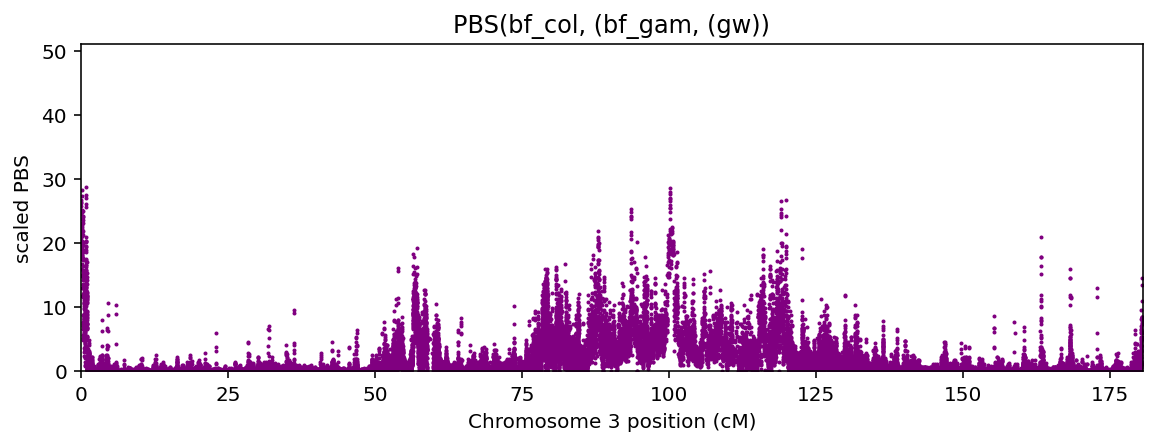

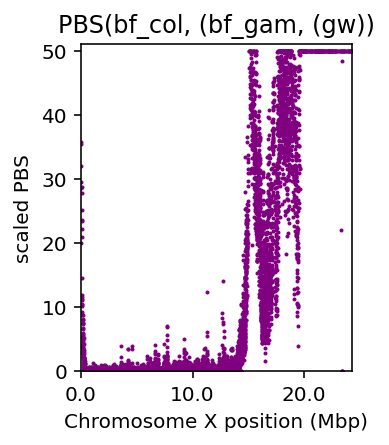

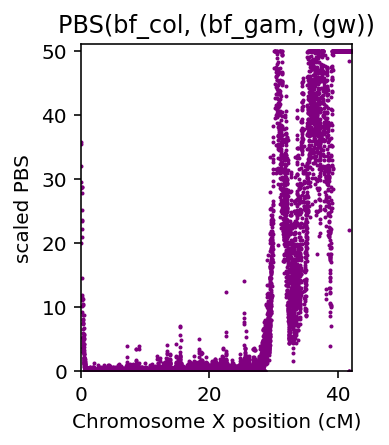

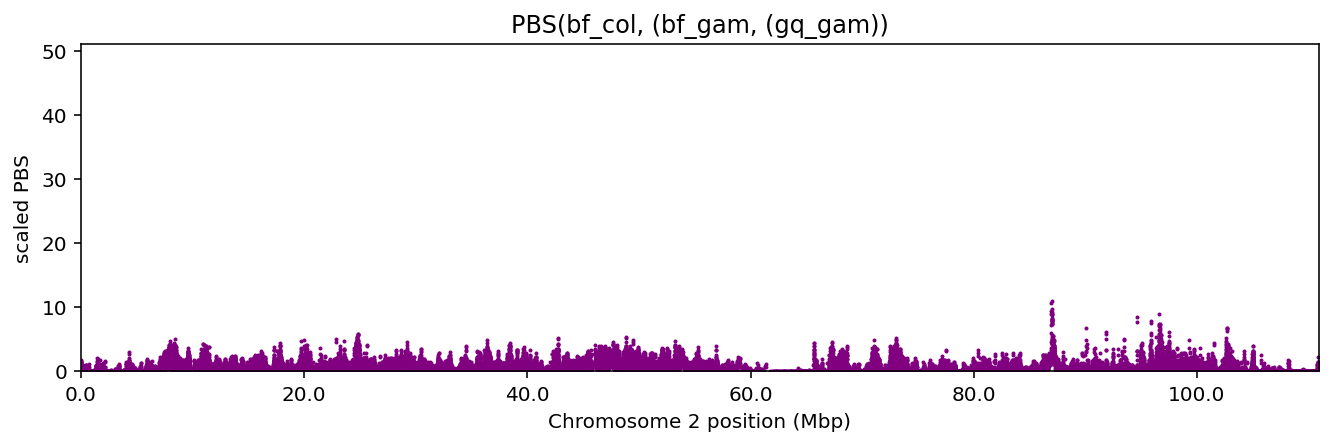

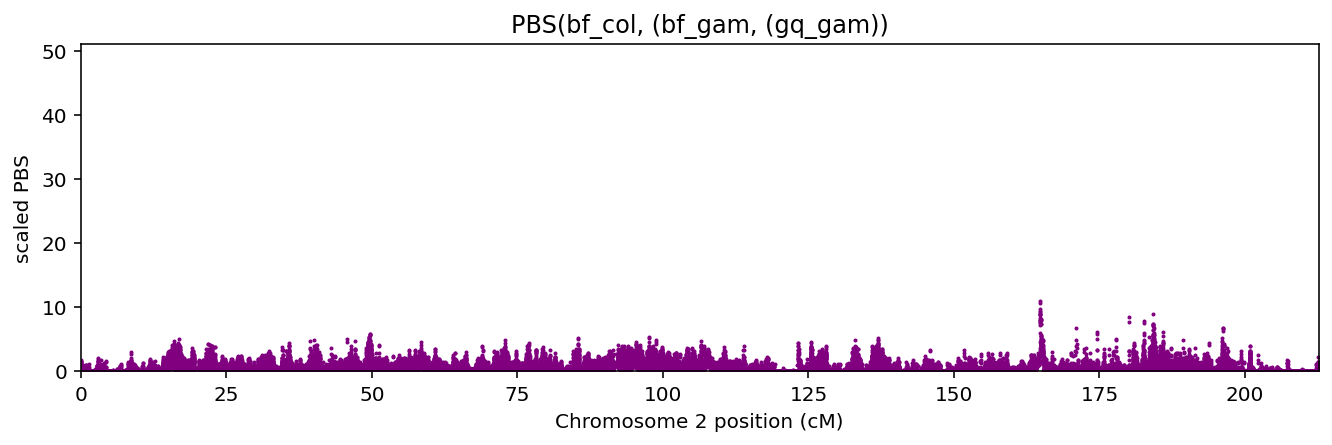

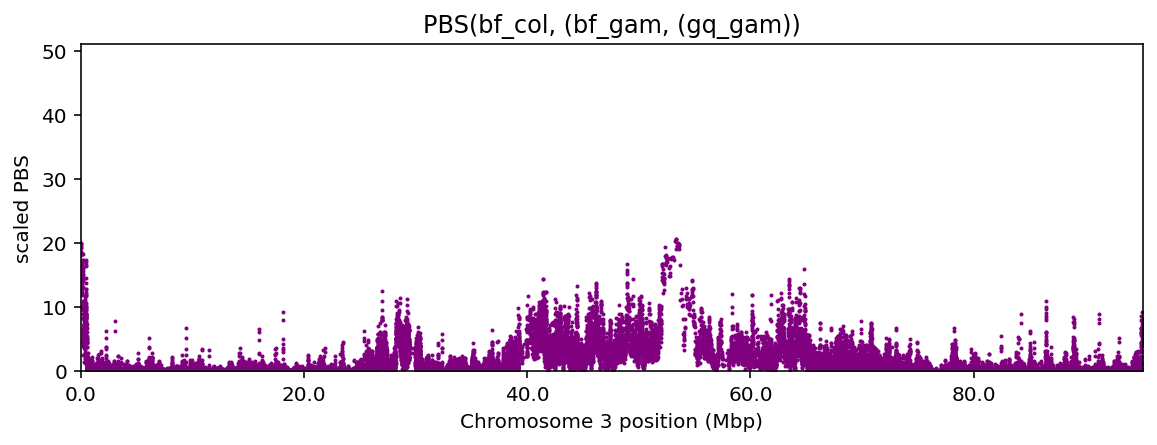

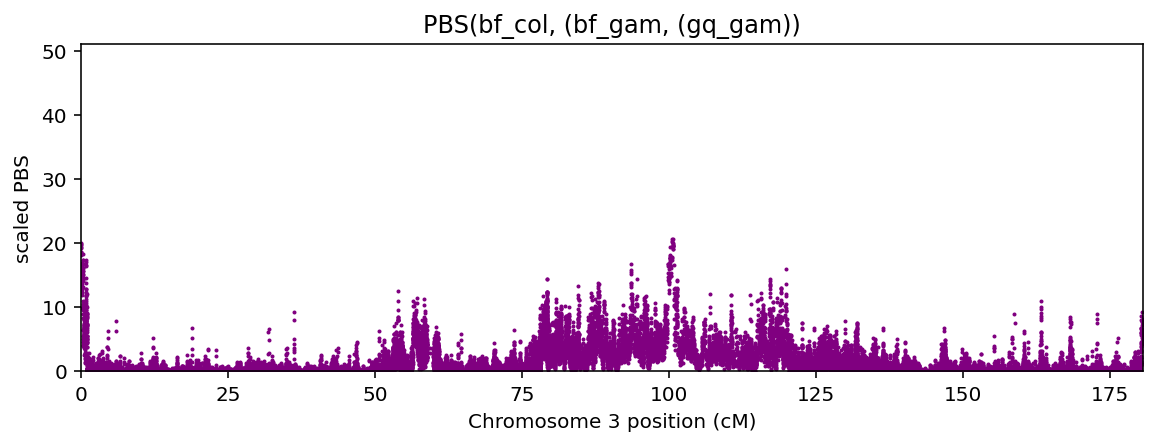

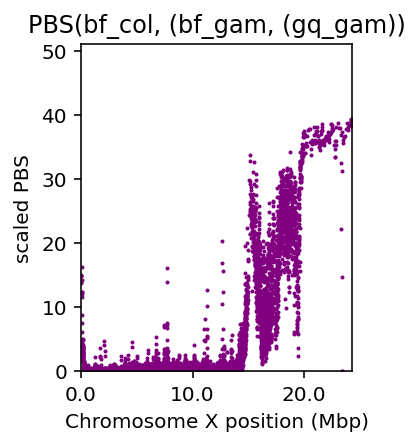

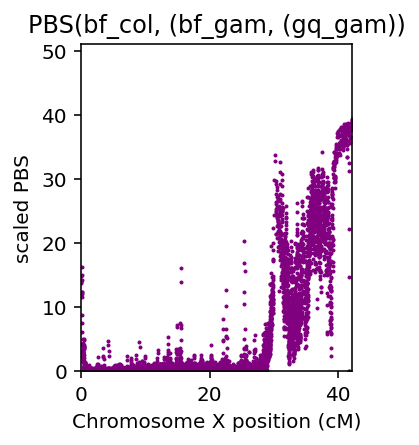

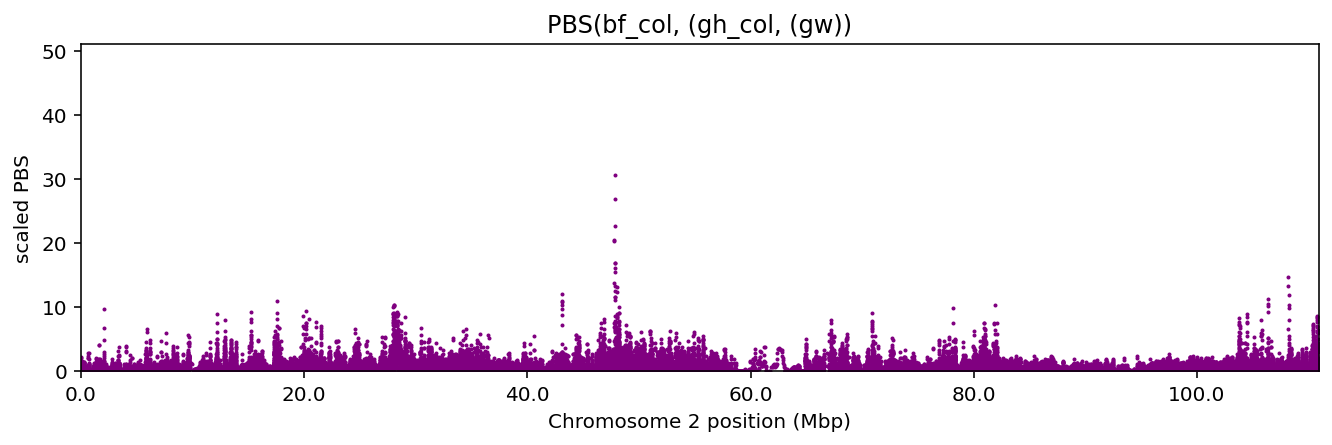

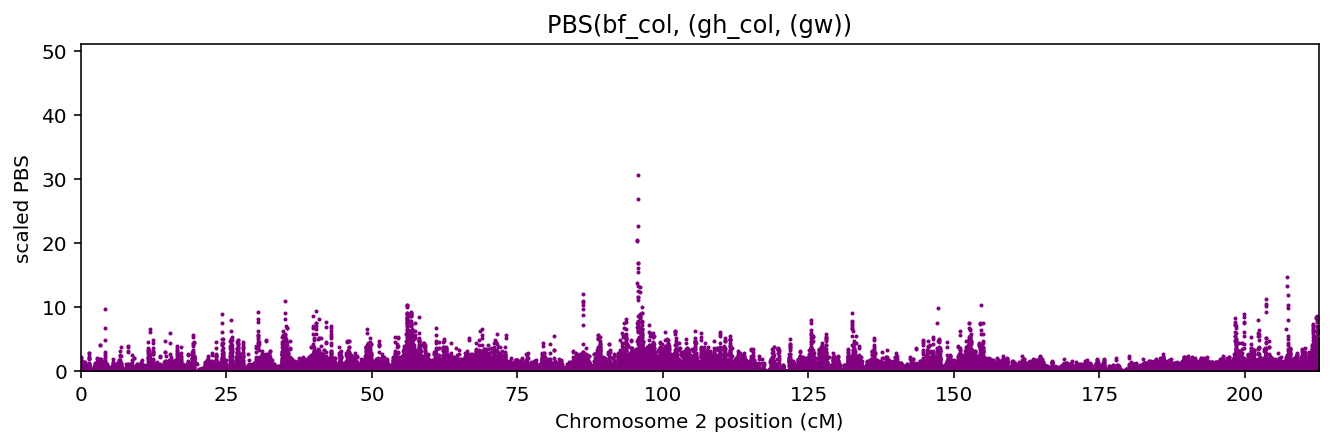

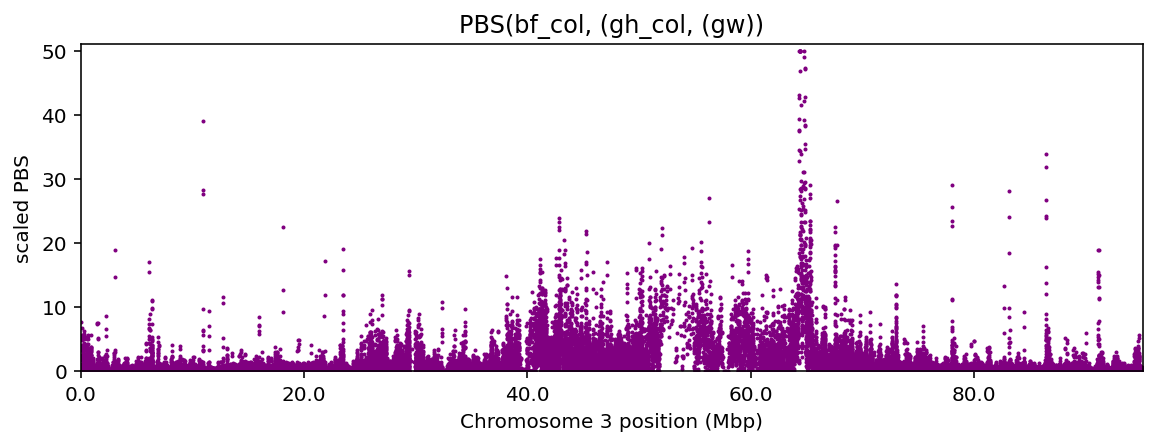

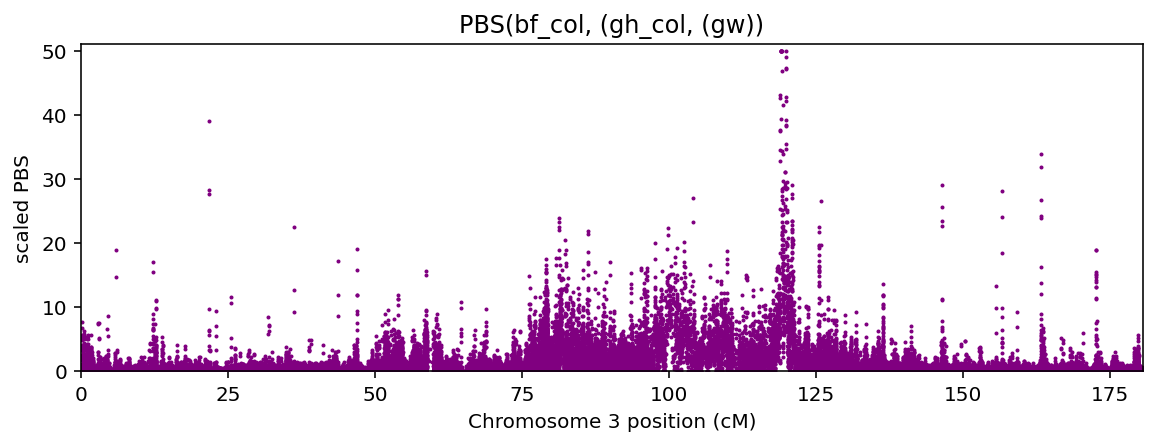

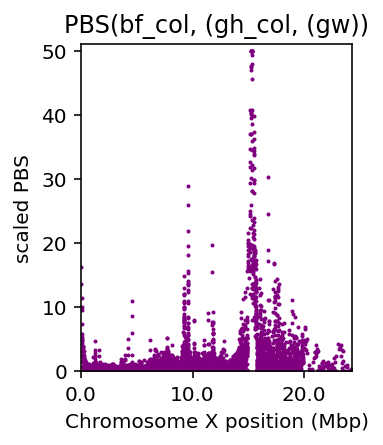

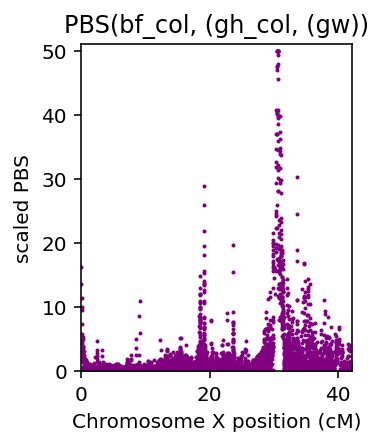

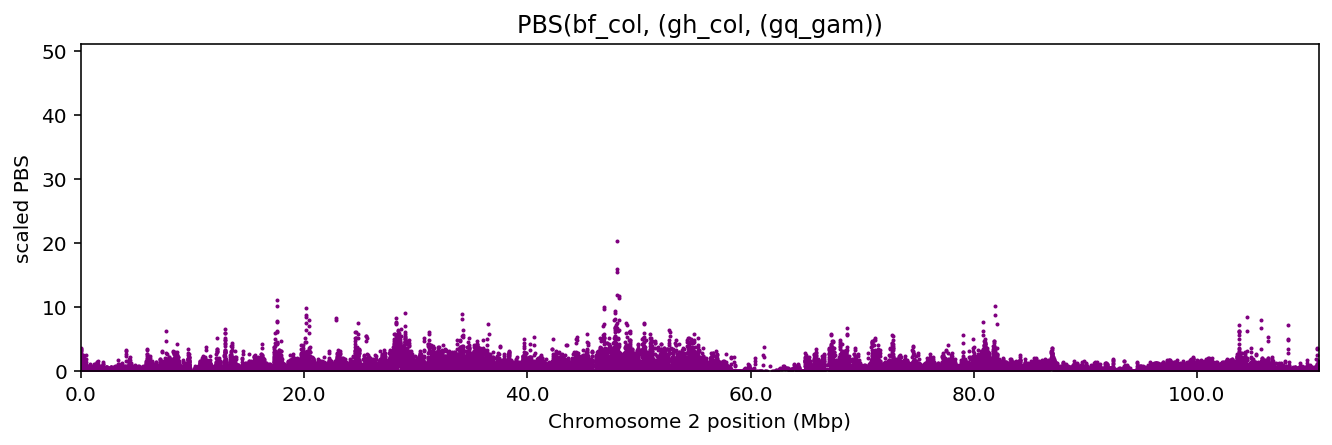

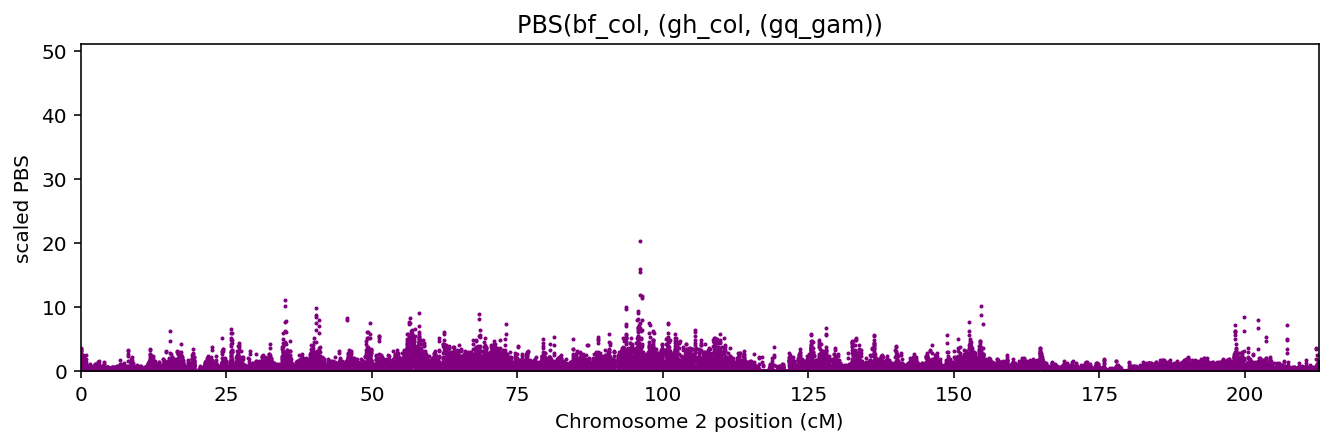

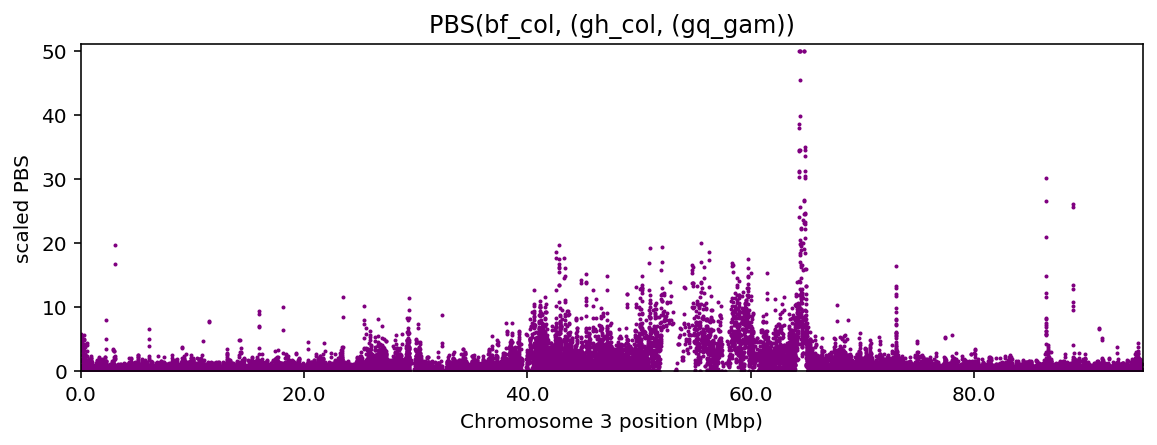

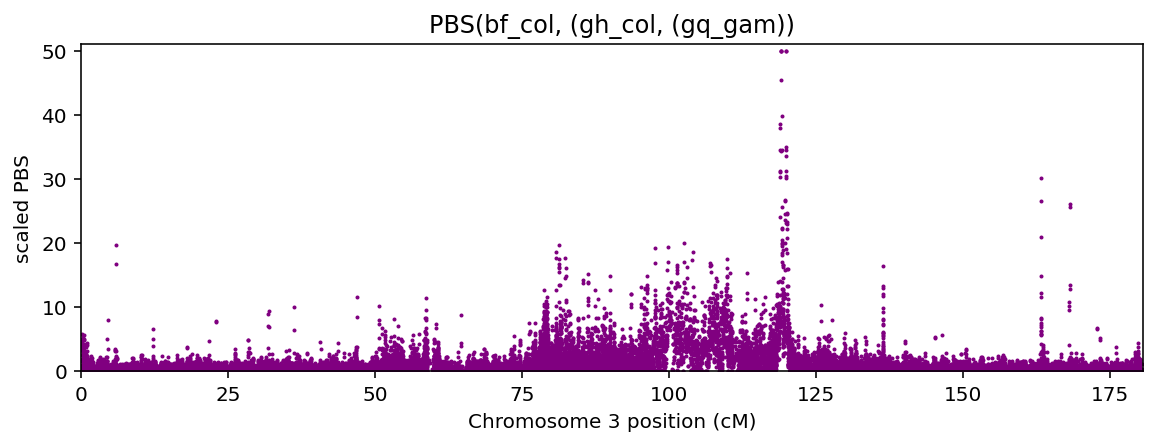

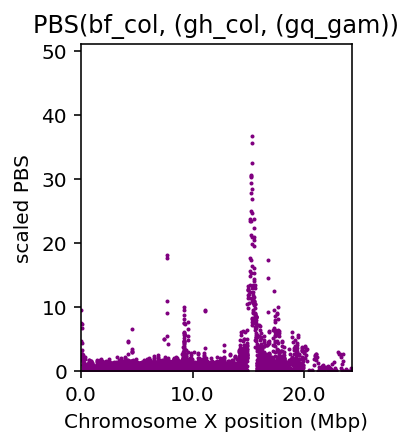

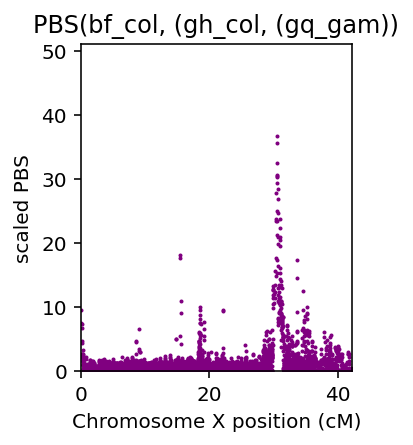

In [ ]:
for pop1, pop2, pop3 in comparisons:
    for chromosome in '2', '3', 'X':
        run_pbs(pop1, pop2, pop3, chromosome, window_size=500, window_step=250)